# Analysis of VoC data

Look at data provided to SPI-M on the B.1.351 VoC. 

Data file not included in the repo, so change path if running independently. 

This version:
* Data is that provided on 7 May
* Be clearer about travel versus non - London non-travel seems to have consistent exp.
* Be clearer about exponential versus constant
* Clearer labels of calendar dates

Note that linkage to the linelist on finalid should be possible.

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.optimize as op
from numpy import linalg as LA

In [2]:
df = pd.read_excel(
    '/Volumes/COVID19_Epi_modelling/DstlDailyData/2021-05-07/VOC202012_02_linelist_20210507.xlsx',
    sheet_name=1,
)
df.dropna(subset=['earliest_specimen_date'],inplace=True)

In [3]:
def todays(x):
    return np.array((pd.to_datetime(x['earliest_specimen_date'], format='%Y-%m-%d') - pd.Timestamp("2020-10-01")) // pd.Timedelta('1D'))

In [4]:
monthstarts = pd.DataFrame([
    '2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01'
],columns=['earliest_specimen_date'])
monthstarts

,earliest_specimen_date
0,2020-10-01
1,2020-11-01
2,2020-12-01
3,2021-01-01
4,2021-02-01
5,2021-03-01
6,2021-04-01
7,2021-05-01


In [5]:
def tods(x):
    return pd.to_datetime(x['earliest_specimen_date'], format='%Y-%m-%d').dt.strftime('%d %b')

In [6]:
keydates = pd.DataFrame([
    ['2021-01-01','Start of 2021'],
    ['2021-03-08','Roadmap Start'],
    ['2021-04-30','Sequence Delay'],
],columns=['earliest_specimen_date','date_name'])
keydates

,earliest_specimen_date,date_name
0,2021-01-01,Start of 2021
1,2021-03-08,Roadmap Start
2,2021-04-30,Sequence Delay


In [7]:
dfr = df.groupby('PHEC_name').apply(todays)

In [8]:
np.max(todays(monthstarts))

212

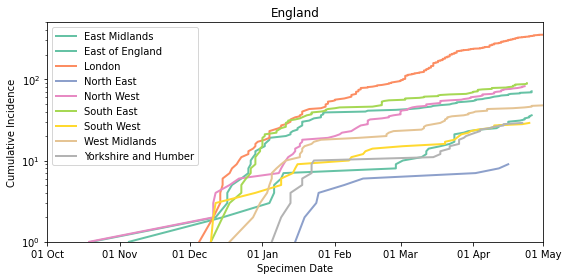

In [9]:
lq = len(dfr.index)
cmp = plt.cm.get_cmap('Set2', lq+1)
plt.figure(figsize=(8,4))
for i in range(0,lq):
    x = dfr[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=dfr.index[i], lw=2, c=cmp(i))
#for i, d in keydates.iterrows():
#    plt.plot(todays(d)*np.ones(2),np.array([0,500]),ls='--',label=d.date_name)
plt.legend()
plt.xlabel('Specimen Date')
plt.ylabel('Cumulative Incidence')
plt.xticks(todays(monthstarts),tods(monthstarts))
plt.xlim([0,212])
plt.ylim([1,500])
plt.yscale('log')
plt.title('England')
plt.tight_layout()
plt.savefig('./figures/voc_region_log.pdf')

In [10]:
# From the above, London is far largest so look at that
li = np.argwhere(dfr.index == 'London')[0]
x = dfr[li].values[0]

In [11]:
dfl = df[df.PHEC_name == 'London']
dfl.reset_index(drop=True,inplace=True)
dfl

,finalid,specimen_date_sk,seq_result,earliest_specimen_date,PHEC_name,exposure_type,survey_or_intervention,hh_id
0,-3311042.0,20210502.0,Provisional Genotyping,2021-05-02,London,Awaiting information,NaN,2.0
1,-3306285.0,20210428.0,Provisional Genotyping,2021-04-28,London,Awaiting information,NaN,277.0
2,-3304744.0,20210501.0,Provisional Genotyping,2021-04-29,London,Awaiting information,NaN,593.0
3,-3304640.0,20210428.0,Provisional Genotyping,2021-04-28,London,Awaiting information,NaN,293.0
4,-3304562.0,20210501.0,Provisional Genotyping,2021-04-29,London,Awaiting information,NaN,512.0
...,...,...,...,...,...,...,...,...
348,1672607.0,20210416.0,Confirmed,2021-04-16,London,Awaiting information,NaN,487.0
349,1672956.0,20210410.0,Confirmed,2021-04-10,London,Not travel-associated,NaN,488.0
350,1673678.0,20210419.0,Confirmed,2021-04-19,London,Awaiting information,NaN,489.0
351,1673679.0,20210420.0,Confirmed,2021-04-20,London,Awaiting information,NaN,490.0


In [12]:
dfg = df.groupby('exposure_type').apply(todays)

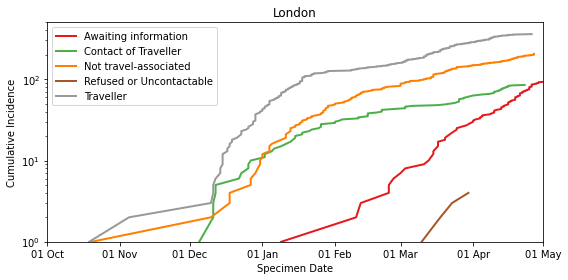

In [13]:
lq = len(dfg.index)
cmp = plt.cm.get_cmap('Set1', lq)
plt.figure(figsize=(8,4))
for i in range(0,lq):
    x = dfg[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=dfg.index[i], lw=2, c=cmp(i))
plt.legend()
plt.xlabel('Specimen Date')
plt.ylabel('Cumulative Incidence')
plt.xticks(todays(monthstarts),tods(monthstarts))
plt.ylim([1,500])
plt.xlim([0,212])
plt.yscale('log')
plt.title('London')
plt.tight_layout()
plt.savefig('./figures/voc_london_log.pdf')

In [14]:
# From the above, Not travel London
li = np.argwhere(dfg.index == 'Not travel-associated')[0]
x = dfg[li].values[0]
len(x)

205

In [15]:
def mymu(x,tt,n):
    mu = np.concatenate([
        x[0]*np.exp(x[1]*tt[0:n]),
        x[0]*np.exp(x[1]*tt[n-1])*np.exp(x[3]*(tt[n:]-tt[n-1]))
    ])
    return mu

def myod(x,tt,n):
    od = np.concatenate([
        x[2]*np.ones(len(tt[0:n])),
        x[4]*np.ones(len(tt[n:]))
    ])
    return od

def mynll(y,x,tt):
    mu = x[0]*np.exp(x[1]*tt)
    od = x[2]*np.ones(len(tt))
    p = 1/od
    r = mu/(od-1)
    return -np.sum(st.nbinom.logpmf(y,r,p))

def mynll2(y,x,tt,n):
    mu = mymu(x,tt,n)
    od = myod(x,tt,n)
    p = 1/od
    r = mu/(od-1)
    return -np.sum(st.nbinom.logpmf(y,r,p))

In [16]:
keydates = pd.DataFrame([
    ['2021-01-01','Start of 2021'],
    ['2021-03-08','Roadmap Start'],
    ['2021-04-30','Sequence Delay'],
],columns=['earliest_specimen_date','date_name'])
keydates

,earliest_specimen_date,date_name
0,2021-01-01,Start of 2021
1,2021-03-08,Roadmap Start
2,2021-04-30,Sequence Delay


In [20]:
tk = todays(keydates)
z = np.bincount(x)
uu = np.arange(0,np.max(x)+1)
yy = z[tk[0]:tk[-1]]
tt = np.arange(0,len(yy))
n = tk[1]-tk[0]

In [21]:
x02 = np.array([1,0.25,5,0.15,5])
nll = lambda xx: mynll2(yy,xx,tt,n)
fout2 = op.minimize(nll,x02,method='Nelder-Mead')   
mu = mymu(fout2.x,tt,n)
od = myod(fout2.x,tt,n)
p = 1/od
r = mu/(od-1)
dt1 = np.log(2.0)/fout2.x[1]
dt2 = np.log(2.0)/fout2.x[3]
print(dt1)
print(dt2)

134.43721331933065
66.07347393719384


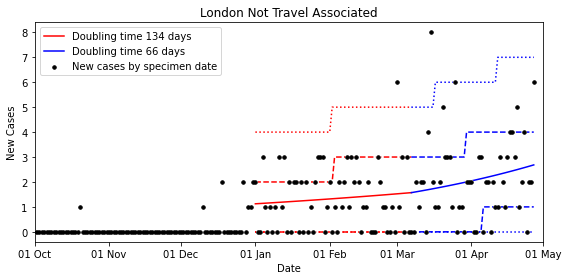

In [22]:
plt.figure(figsize=(8,4))
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.xticks(todays(monthstarts),tods(monthstarts))
plt.plot(tk[0]+tt[0:n],mu[0:n],linestyle='-',c='r',label='Doubling time {:.0f} days'.format(dt1))
plt.plot(tk[0]+tt[(n-1):],mu[(n-1):],linestyle='-',c='b',label='Doubling time {:.0f} days'.format(dt2))
plt.plot(tk[0]+tt[0:n],st.nbinom.ppf(1/6,r[0:n],p[0:n]),linestyle='--',c='r')
plt.plot(tk[0]+tt[0:n],st.nbinom.ppf(5/6,r[0:n],p[0:n]),linestyle='--',c='r')
plt.plot(tk[0]+tt[(n-1):],st.nbinom.ppf(1/6,r[(n-1):],p[(n-1):]),linestyle='--',c='b')
plt.plot(tk[0]+tt[(n-1):],st.nbinom.ppf(5/6,r[(n-1):],p[(n-1):]),linestyle='--',c='b')
plt.plot(tk[0]+tt[0:n],st.nbinom.ppf(0.025,r[0:n],p[0:n]),linestyle=':',c='r')
plt.plot(tk[0]+tt[0:n],st.nbinom.ppf(0.975,r[0:n],p[0:n]),linestyle=':',c='r')
plt.plot(tk[0]+tt[(n-1):],st.nbinom.ppf(0.025,r[(n-1):],p[(n-1):]),linestyle=':',c='b')
plt.plot(tk[0]+tt[(n-1):],st.nbinom.ppf(0.975,r[(n-1):],p[(n-1):]),linestyle=':',c='b')
plt.scatter(uu,z,marker='o',c='w',s=16,zorder=3)
plt.scatter(uu,z,marker='o',c='k',s=12,label='New cases by specimen date',zorder=3)
plt.xlim([0,212])
plt.legend()
plt.title('London Not Travel Associated')
plt.tight_layout()
plt.savefig('./figures/voc_london_nta_fit.pdf')

In [23]:
xhat = fout2.x
xhat

array([1.12430246, 0.00515592, 1.29482544, 0.01049055, 1.40135644])

In [24]:
pn = len(x02)
delta = 1e-2 # Some tuning of this by hand is inevitable
dx = delta*xhat
ej = np.zeros(pn)
ek = np.zeros(pn)
Hinv = np.zeros((pn,pn))
for j in range(0,pn):
    ej[j] = dx[j]
    for k in range(0,j):
        ek[k] = dx[k]
        Hinv[j,k] = nll(xhat+ej+ek) - nll(xhat+ej-ek) - nll(xhat-ej+ek) + nll(xhat-ej-ek)
        ek[k] = 0.
    Hinv[j,j] = - nll(xhat+2*ej) + 16*nll(xhat+ej) - 30*nll(xhat) + 16*nll(xhat-ej) - nll(xhat-2*ej)
    ej[j] = 0.
Hinv += np.triu(Hinv.T,1)
Hinv /= (4.*np.outer(dx,dx) + np.diag(8.*dx**2)) # TO DO: replace with a chol ...
covmat = LA.inv(0.5*(Hinv+Hinv.T))
stds = np.sqrt(np.diag(covmat))
print(stds)

[0.26509632 0.00519759 0.28338963 0.00597192 0.28357679]


In [25]:
dfs = pd.read_csv('./perc_r_lon.csv')

In [26]:
def stodays(x):
    return np.array((pd.to_datetime(x['Date'], format='%d-%b-%y') - pd.Timestamp("2020-10-01")) // pd.Timedelta('1D'))

In [27]:
gl = dfs.Lower.values/100
gu = dfs.Upper.values/100
gt = stodays(dfs)-7 # Assume that the SPI-M estimates come with a 7 day delay

In [28]:
rt = np.array([tk[0],tk[1],tk[1],tk[2]])
rl = np.concatenate([(xhat[1]-1.96*stds[1])*np.ones(2), (xhat[3]-1.96*stds[3])*np.ones(2)])
ru = np.concatenate([(xhat[1]+1.96*stds[1])*np.ones(2), (xhat[3]+1.96*stds[3])*np.ones(2)])
rm = np.concatenate([(xhat[1])*np.ones(2), (xhat[3])*np.ones(2)])

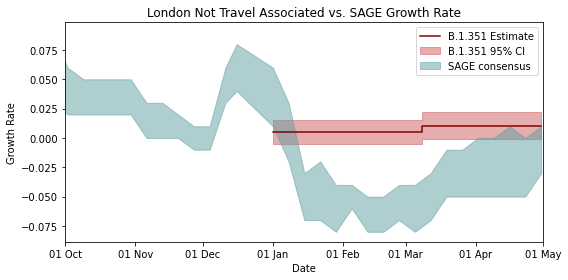

In [29]:
#plt.plot(gt,gl)
#plt.plot(gt,gu)
plt.figure(figsize=(8,4))
plt.xlabel('Date')
plt.ylabel('Growth Rate')
plt.xticks(todays(monthstarts),tods(monthstarts))
plt.plot(rt,rm,color='maroon',label='B.1.351 Estimate')
plt.fill_between(rt,rl,ru,color='indianred',alpha=0.5,label='B.1.351 95% CI')
plt.fill_between(gt,gl,gu,color='cadetblue',alpha=0.5,label='SAGE consensus')
#plt.plot(np.array([tk[0],tk[1]]),xhat[1]*np.ones(2))
#plt.plot(np.array([tk[1],tk[2]]),xhat[3]*np.ones(2))
plt.xlim([0,212])
plt.legend()
plt.title('London Not Travel Associated vs. SAGE Growth Rate')
plt.tight_layout()
plt.savefig('./figures/voc_london_nta_comp.pdf')